<a href="https://colab.research.google.com/github/alimoorreza/CS143-SP26-P1/blob/main/p1_street_sweeper_reza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street Sweeper World for Reflex and Model-based Agents

This notebook demonstrates how to make an AI agent which interacts with a simulated street network environment to clean streets. It's like the Vacuum World example in the Russell-Norvig text, but on a real-world street map.

First, let's install a `mapbots` module for this expercise. It uses the [OSMnx](https://osmnx.readthedocs.io/en/stable/) library to retrieve map data from [OpenStreetMap](https://www.openstreetmap.org).

In [1]:
import sys

!{sys.executable} -m pip install mapbots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.8 MB/s eta 0:00:00


## Getting started

First, let's import the `StreetSweeperWorld` class, which will be used to simulate the bot's environment and keep track of some important stats about your bot.

We start by creating a `dsm_bot` object and displaying the map.

In [ ]:
from mapbots import StreetSweeperWorld

dsm_bot = StreetSweeperWorld(place="Des Moines, IA, USA", map_number=4)
dsm_bot.display_map()

In [ ]:
from mapbots import StreetSweeperWorld
la_bot = StreetSweeperWorld(place='Omaha, NE, USA')
la_bot.display_map()

In [ ]:
from mapbots import StreetSweeperWorld
la_bot = StreetSweeperWorld(place='Los Angeles, CA, USA')
la_bot.display_map()

If you don't specify a place, this will just use Des Moines by default. You can try other places, though I have not thoroughly tested how well this exercise works in other locations.

The white lines represent **clean streets**, and the red lines represnt **dirty streets**. The bots task is to clean the dirty streets. The map is for you, the user, to see what's going on - the bot (shown as a blue dot) can't see the whole map.

By default, the dirty regions will be randomly generated. If you want to use the same map more than once (so you can try different ideas on the same map), then specify a `map_number`, which will seed the random number generator so it always generates the map in the same way.

## What can the bot perceive?

The bot can get some information by calling these methods.

**Battery Life:** The bot starts with 72000 battery life - this roughly represents the number of seconds (20 hours) that the bot could move if it was driving around and not doing any cleaning. As the bot performs actions, the battery life will decrease.

**Meters Cleaned:** This shows the total length of streets that the bot has successfully cleaned - initially it's 0 because it hasn't done any cleaning yet. OSMnx uses meters by default, so that's what we'll go with.

**Bot's Location:** The bot can get some info about its location, which is always an intersection between two or more sections of streets or the end of a street section (the bot can only stop and look this info up when it is at these intersections). The `x` and `y` values are the latitude and longitude of the locations, and the `location_id` is a unique identifier for this location within OSM.

In [ ]:
curr_battery = dsm_bot.get_battery_life()
print("Current life battery remaining: ", curr_battery)
curr_dirt_cleaned = dsm_bot.get_meters_cleaned()
print("Bot has cleaned", curr_dirt_cleaned, "meters of dirt so far")
curr_location_data = dsm_bot.get_current_location()
print("Current location data:", curr_location_data)

Current life battery remaining:  72000
Bot has cleaned 0 meters of dirt so far
Current location data: {'y': 41.624991, 'x': -93.600543, 'street_count': 4, 'location_id': 160868165}


Note that the location data is a dictionary, so you could access specific parts of it like this:

In [ ]:
print("Here's the location id of the location where the bot is:",curr_location_data["location_id"])

Here's the location id of the location where the bot is: 160868165


The bot can also see information about what streets it could move to next from its current location. In this case, there are three streets given in a list. Each street has lots of useful information

**start:** this is the endpoint of the street section you're on - it's the same info that you'd get from `get_current_location()`

**end:** this is the info about the other endpoint of the street - it's the location you'd be in if you followed this section of street.

**street_data:** useful data about the section of street. Some examples are
* **name:** the street's name in real life
* **length:** how long the street is (in meters)
* **speed_kph:** how fast you can drive on this street (in kilometers per hour)
* **travel_time:** how long it takes a car (or your bot) to traverse this section of the street
* **cleanliness:** this is either *clean* or *dirty* - your bot will be interested in this

In [ ]:
curr_streets = dsm_bot.scan_next_streets()
#print(curr_streets)
for idx, street in enumerate(curr_streets):
  print("street#", idx+1, "\n", street)
#display(curr_streets) #inside notebooks, you can use display instead of print

street# 1 
 {'start': {'y': 41.624991, 'x': -93.600543, 'street_count': 4, 'location_id': 160868165}, 'end': {'y': 41.624984, 'x': -93.602223, 'street_count': 3, 'location_id': 160935467}, 'street_data': {'osmid': 16013667, 'highway': 'residential', 'name': 'Henderson Avenue', 'oneway': False, 'reversed': True, 'length': np.float64(139.64253804818154), 'speed_kph': 41.22691975308642, 'travel_time': 12.193807831976539, 'cleanliness': 'dirty'}}
street# 2 
 {'start': {'y': 41.624991, 'x': -93.600543, 'street_count': 4, 'location_id': 160868165}, 'end': {'y': 41.625, 'x': -93.597973, 'street_count': 4, 'location_id': 160872131}, 'street_data': {'osmid': 16013667, 'highway': 'residential', 'name': 'Henderson Avenue', 'oneway': False, 'reversed': False, 'length': np.float64(213.61883436197417), 'geometry': <LINESTRING (-93.601 41.625, -93.6 41.625, -93.598 41.625)>, 'speed_kph': 41.22691975308642, 'travel_time': 18.65353531888674, 'cleanliness': 'dirty'}}
street# 3 
 {'start': {'y': 41.62499

since this is a list, if you just wanted to grab one item from the list, you could use a subscript like this:

In [ ]:
one_of_the_streets = curr_streets[0]
display(one_of_the_streets)

{'start': {'y': 41.624991,
  'x': -93.600543,
  'street_count': 4,
  'location_id': 160868165},
 'end': {'y': 41.624984,
  'x': -93.602223,
  'street_count': 3,
  'location_id': 160935467},
 'street_data': {'osmid': 16013667,
  'highway': 'residential',
  'name': 'Henderson Avenue',
  'oneway': False,
  'reversed': True,
  'length': np.float64(139.64253804818154),
  'speed_kph': 41.22691975308642,
  'travel_time': 12.193807831976539,
  'cleanliness': 'dirty'}}

and if you wanted to grab the location id of the **end** of this section from the first item in the list, you could do it like this:

In [ ]:
id_to_move_to = curr_streets[0]["end"]["location_id"]
print(id_to_move_to)

160935467


## What actions can the bot take?

One action the bot can make is to move to an adjacent location. We could take the id we obtained above and pass it to the `move_to` method like this. It returns the id of our new location.

In [ ]:
dsm_bot.move_to(id_to_move_to)

160935467

We can then scan for more streets, and you'll notice they're different!

In [ ]:
curr_streets = dsm_bot.scan_next_streets()
for idx, street in enumerate(curr_streets):
  print("street#", idx+1, "\n", street)

street# 1 
 {'start': {'y': 41.624984, 'x': -93.602223, 'street_count': 3, 'location_id': 160935467}, 'end': {'y': 41.625893, 'x': -93.602226, 'street_count': 4, 'location_id': 160871054}, 'street_data': {'osmid': 16010997, 'highway': 'residential', 'name': 'York Street', 'oneway': False, 'reversed': False, 'length': np.float64(101.07663868646189), 'speed_kph': 41.22691975308642, 'travel_time': 8.826172351719814, 'cleanliness': 'dirty'}}
street# 2 
 {'start': {'y': 41.624984, 'x': -93.602223, 'street_count': 3, 'location_id': 160935467}, 'end': {'y': 41.624991, 'x': -93.600543, 'street_count': 4, 'location_id': 160868165}, 'street_data': {'osmid': 16013667, 'highway': 'residential', 'name': 'Henderson Avenue', 'oneway': False, 'reversed': False, 'length': np.float64(139.64253804818154), 'speed_kph': 41.22691975308642, 'travel_time': 12.193807831976539, 'cleanliness': 'dirty'}}
street# 3 
 {'start': {'y': 41.624984, 'x': -93.602223, 'street_count': 3, 'location_id': 160935467}, 'end': {

In this case, notice that the second street in the list has `"dirty"` as its `"cleanliness"` value. If we want to follow that street **and clean it** then we call the `clean_and_move_to` method like this:

In [ ]:
id_to_move_to_and_clean = curr_streets[1]["end"]["location_id"]
dsm_bot.clean_and_move_to(id_to_move_to_and_clean)

160868165

Notice that the bot's battery has decreased, and it has recorded that it has done some cleaning.

In [ ]:
curr_battery = dsm_bot.get_battery_life()
print("Current life battery remaining:",curr_battery)

curr_amount_cleaned = dsm_bot.get_meters_cleaned()
print("We have cleaned",curr_amount_cleaned,"meters so far")

curr_loc_data = dsm_bot.get_current_location()
print("Current location data:",curr_loc_data)

Current life battery remaining: 71951.22476867208
We have cleaned 139.64253804818154 meters so far
Current location data: {'y': 41.624991, 'x': -93.600543, 'street_count': 4, 'location_id': 160868165}


### Battery Rules

The amount of battery your bot uses is equal to the `"travel_time"` of any street it moves over with a `move_to`. If you do a `clean_and_move_to`, it takes three times as much battery power as a `move_to`.

Since the `clean_and_move_to` we did was over a street with 12.19 travel time, it took 12.19*3=36.57 power. The travel time of the first `move_to` was 12.19, so the total battery power used was 12.19+36.57 = 48.76. Initially, there was 72000 power. So current battery remaining is rightly 71951.24.

If you display the map again, you will also notice that the blue dot has moved, leaving a semi-transparent blue path behind it showing where the bot has been.

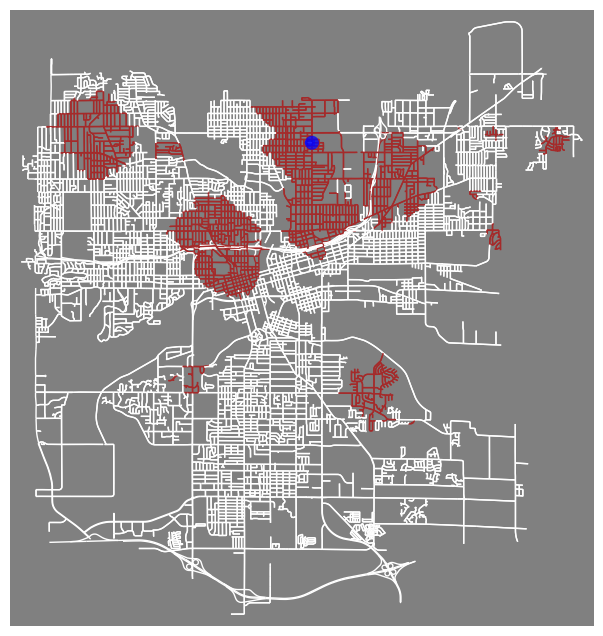

In [ ]:
dsm_bot.display_map()

## Making a bot

One very simple bot could work like this. It just keeps going until the battery is dead. At each point, it scans streets for the next move, chooses one at random, and then cleans that randomly selected street.

As is, this results in an error because it is possible to get stuck in one-way dead-ends, which is probably just an error in the map data.

Final location: {'y': 41.619093, 'x': -93.675575, 'street_count': 3, 'location_id': 160817606}
Final battery life: -5.455956197813297
Total distance cleaned (meters): 39716.44023858075


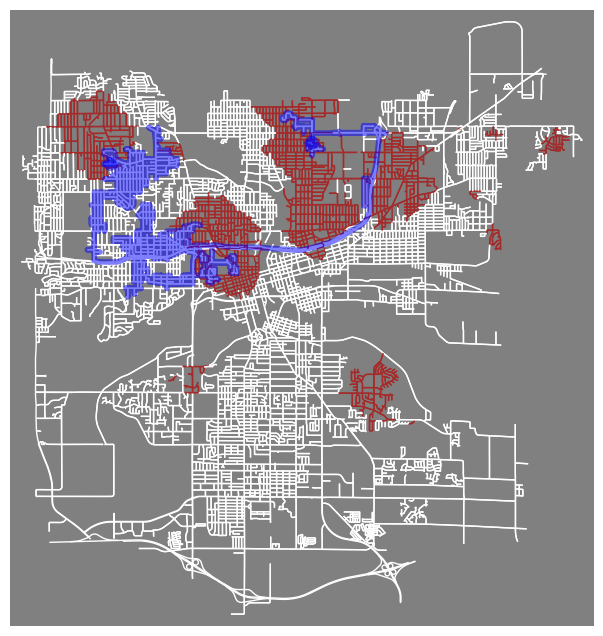

In [ ]:
import random
random.seed(10)

while dsm_bot.get_battery_life() > 0:

    move_options = dsm_bot.scan_next_streets()
    chosen_street = random.choice(move_options)
    dsm_bot.clean_and_move_to(chosen_street["end"]["location_id"])

print("Final location:",dsm_bot.get_current_location())
print("Final battery life:",dsm_bot.get_battery_life())
print("Total distance cleaned (meters):",dsm_bot.get_meters_cleaned())
dsm_bot.display_map()

To help you get out of this, there is a `backup` method that we can call if there are no move options. You can specificy how many levels you want to back out. Backing up doesn't use up any of your battery power (though you did use battery getting stuck in the first place).

Final location: {'y': 41.619093, 'x': -93.675575, 'street_count': 3, 'location_id': 160817606}
Final battery life: -5.455956197813297
Total distance cleaned (meters): 39716.44023858075


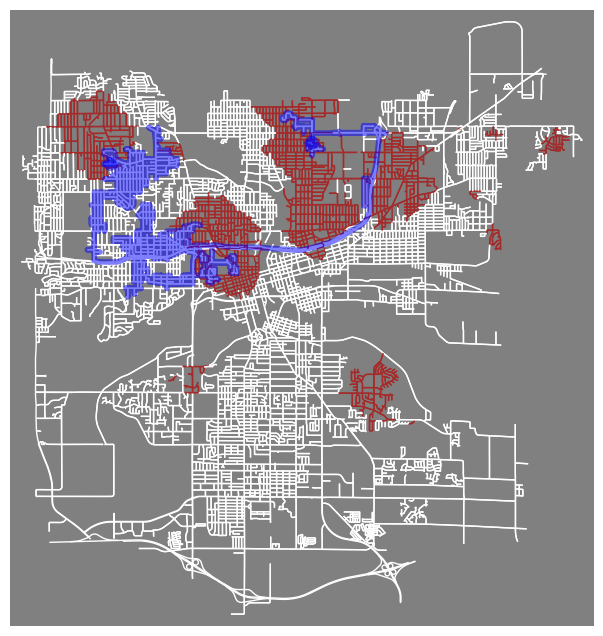

In [ ]:
import random
random.seed(10)
while dsm_bot.get_battery_life() > 0:

    move_options = dsm_bot.scan_next_streets()
    if move_options == []:
        dsm_bot.backup(how_many=5)
    else:
        chosen_street = random.choice(move_options)
        dsm_bot.clean_and_move_to(chosen_street["end"]["location_id"])

print("Final location:",dsm_bot.get_current_location())
print("Final battery life:",dsm_bot.get_battery_life())
print("Total distance cleaned (meters):",dsm_bot.get_meters_cleaned())
dsm_bot.display_map()

## Making a better bot

This first bot isn't very smart at all - it just cleans indiscriminantly. Since it takes extra power to clean, let's improve it and only cleaning if street is actually dirty.

Setting up the map. This may take a few minutes.


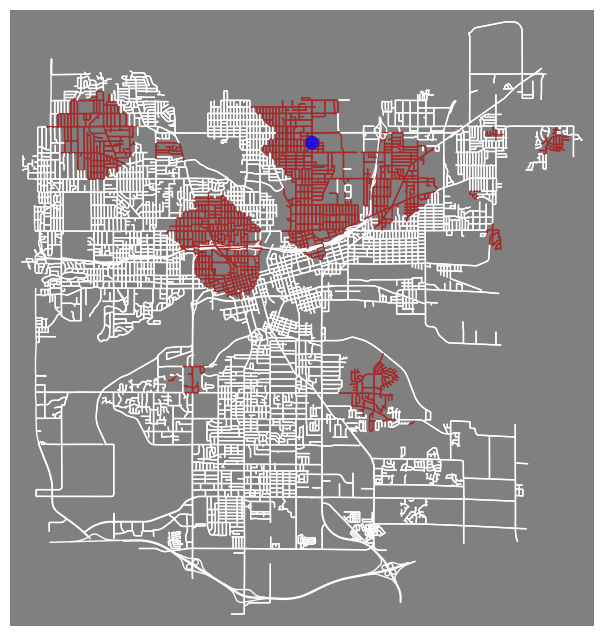

Final location: {'y': 41.5965746, 'x': -93.5632185, 'street_count': 4, 'location_id': 160964085}
Final battery life: -4.706272347500871
Total distance cleaned (meters): 107085.28023592285


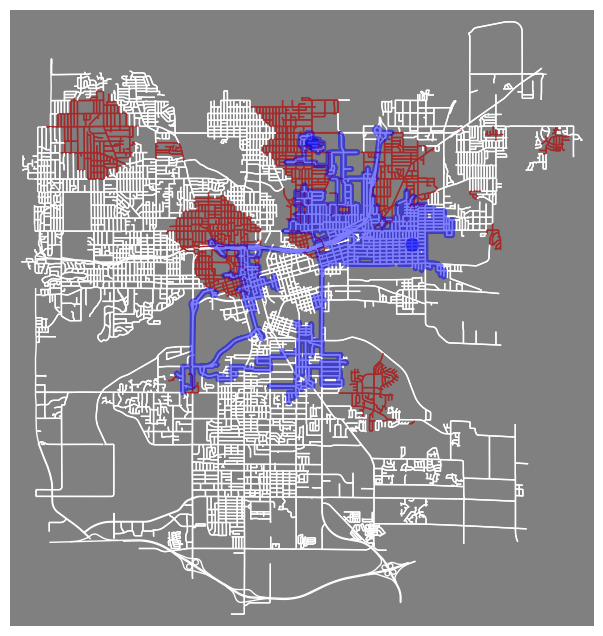

In [4]:
from mapbots import StreetSweeperWorld
import random
random.seed(10)

random_bot = StreetSweeperWorld(place="Des Moines, Iowa, USA",map_number=4)
random_bot.display_map()

while random_bot.get_battery_life() > 0:

    move_options = random_bot.scan_next_streets()
    if move_options == []:
        random_bot.backup(how_many=5)
    else:
        chosen_street = random.choice(move_options)

        # a new feature - let's decide whether to clean or just move based
        # on whether the street's cleanliness value is actually dirty
        if chosen_street["street_data"]["cleanliness"] == "dirty":
            random_bot.clean_and_move_to(chosen_street["end"]["location_id"])
        else:
            random_bot.move_to(chosen_street["end"]["location_id"])

print("Final location:",random_bot.get_current_location())
print("Final battery life:",random_bot.get_battery_life())
print("Total distance cleaned (meters):",random_bot.get_meters_cleaned())
random_bot.display_map()

this seems to have improved the total distance cleaned since it was able to cover more streets with the saved battery life.

### Exercise#1:

Try this on some different map numbers and keep track of the difference between these two approaches on average.

### Exercise#2:

Change the code so that if some of `move_options` are clean and some are dirty, it will select a dirty one. How can you tell whether this approach is better on average?

Setting up the map. This may take a few minutes.


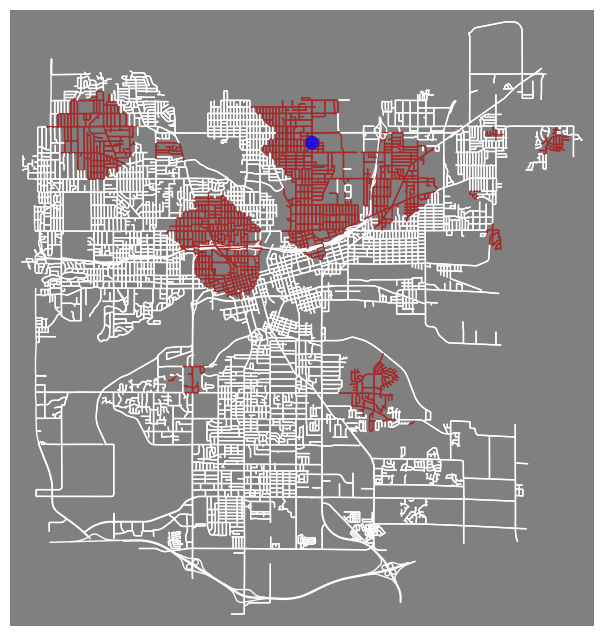

Final location: {'y': 41.5905105, 'x': -93.6244422, 'highway': 'traffic_signals', 'street_count': 4, 'location_id': 390953069}
Final battery life: -12.106811166908804
Total distance cleaned (meters): 193554.78047792107


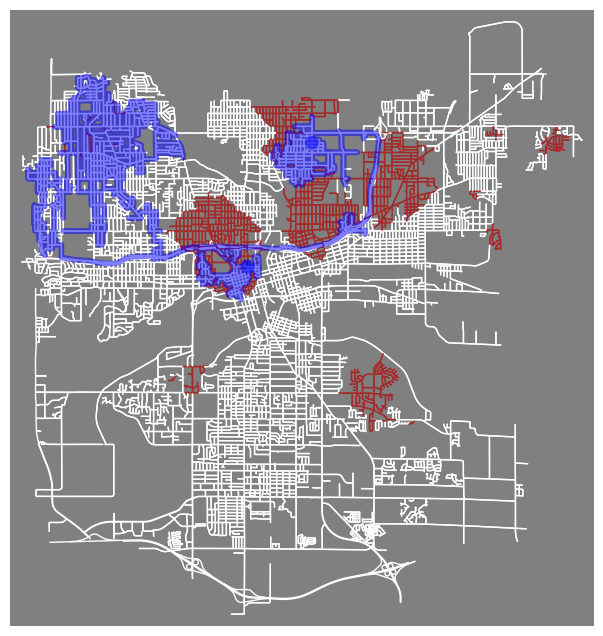

In [6]:
import random
random.seed(10)

random_bot = StreetSweeperWorld(place="Des Moines, Iowa, USA",map_number=4)
random_bot.display_map()

while random_bot.get_battery_life() > 0:

    move_options = random_bot.scan_next_streets()
    if move_options == []:
        random_bot.backup(how_many=5)
    else:
        move_options_dirty = []
        for chosen_street in move_options:
          if chosen_street["street_data"]["cleanliness"] == "dirty":
            move_options_dirty.append(chosen_street)

        # if none of the selected street are dirty then pick a random one
        if move_options_dirty == []:
          chosen_street_final = random.choice(move_options)
        else:
          chosen_street_final = random.choice(move_options_dirty)

        # a new feature - let's decide whether to clean or just move:
        # if some of move_options are clean and some are dirty, it will select a dirty one
        if chosen_street_final["street_data"]["cleanliness"] == "dirty":
            random_bot.clean_and_move_to(chosen_street_final["end"]["location_id"])
        else:
            random_bot.move_to(chosen_street_final["end"]["location_id"])

print("Final location:",random_bot.get_current_location())
print("Final battery life:",random_bot.get_battery_life())
print("Total distance cleaned (meters):",random_bot.get_meters_cleaned())
random_bot.display_map()

## Assignment

The agent we designed in this demo are reflex agents - they make decisions based only on what they perceive in this moment. Come up with a strategy for a model-based agent
* this means that you should keep track of something - for example, what locations you have been to or how dirty of an area you seem to be in (e.g., how many dirty streets have you scanned in the last 20 actions?)
* make rational decisions based on the current percepts and the state that you're keeping track of

Implementation idea/suggestion:
* define variables to keep track of the dirty locations
* introduce a dictionary to store dirty locations with its distance from the robot's current position, eg, `key` in this dictionary could be `(r,c)` and `value` could be distance


Implement the idea and test it out. Compare it on at least 10 different map numbers against the best reflex-only agent you tried in this lab. Create a Jupyter Notebook like this one where you run your experiments and display the results. Include a markdown cell (like this one you're reading right now) where you describe your model-based agent's idea. Use headers/sections like this:

### Idea behind my model-based agent

In this section, write how your model-based agent works and *say what it is about it that makes it model-based*. You should also say why this is a reasonable approach - why do you think it *could* be an improvement.

### Results

Here you should describe the results of your experiment and come to a conclusion about which bot idea was best - it's ok if your model-based idea isn't better (or even if it is only a little better) as long as you run a good test showing it.

### Grading

The assignment will be worth 8 points.
* You can get up to 1 point if you turn in the starter notebook and you ran all the code yourself. Create a markdown cell at the top where you explain that's what you did.
* You can get up to 4 points if you turn in the starter notebook and you attempted each of the lab exercises.
* You can get up to 8 points if you implemented a model-based agent, performed an experiment where you compared it against one of the reflex-only agents, and wrote-up your description and results as directed above. Partial credit (5-7 points) will be given if any of these parts are incomplete.

### Turning it in

You should submit your Jupyter Notebook to the handin form on Blackboard. You can either submit a link to a shared version of your notebook from Google Colab (make it sharable so that anyone with the link can view it) or you can directly attach the .ipynb file to the handin form.